In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import Resize, CenterCrop, Normalize, Compose, TrivialAugmentWide

from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import vit_l_16, ViT_L_16_Weights, vision_transformer
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import os
from tqdm.auto import tqdm

from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

c:\Users\ANT-PC\anaconda3\envs\autodrive-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.transforms import ToTensor
from torchvision.transforms import CenterCrop

train_transform = Compose(
    [
        TrivialAugmentWide(num_magnitude_bins=31),
        Resize([384, 384]),
        CenterCrop(384),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = Compose(
    [
        ToTensor(),
        Resize([384, 384]),
        CenterCrop(384),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [3]:
import pandas as pd


class CarsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.cars_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes = list(self.cars_frame.iloc[:, 1].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.cars_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        img_name = os.path.join(self.root_dir, self.cars_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = torch.tensor(self.cars_frame.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
BATCH_SIZE = 16

from torch.utils.data import DataLoader

train_dataset = CarsDataset("train.csv", "data", transform=train_transform)
test_dataset = CarsDataset("test.csv", "data", transform=EfficientNet_V2_S_Weights.DEFAULT.transforms())
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [5]:
EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 383.5, 383.5, -0.5)

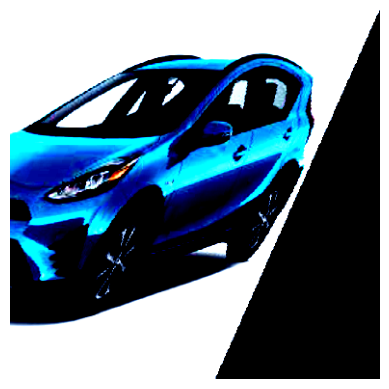

In [6]:
import matplotlib.pyplot as plt
data = next(iter(train_dataloader))
plt.imshow(data[0][0].permute((1,2,0)))
plt.axis('off')

In [7]:
import torchmetrics
device = "cuda" if torch.cuda.is_available() else "cpu"
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)

# for parameter in model.parameters():
#     parameter.requires_grad = False

model.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(in_features=1280, out_features=len(train_dataset.classes)))

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_acc_metric = torchmetrics.Accuracy(task = "multiclass", num_classes = len(train_dataset.classes)).to(device)
test_acc_metric = torchmetrics.Accuracy(task = "multiclass", num_classes = len(test_dataset.classes)).to(device)


In [8]:
# import torchmetrics
# device = "cuda" if torch.cuda.is_available() else "cpu"
# weights = ViT_L_16_Weights.DEFAULT
# model = vit_l_16()

# # for parameter in model.parameters():
# #     parameter.requires_grad = False

# model.heads = nn.Linear(in_features = 1024, out_features=len(train_dataset.classes))
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# train_acc_metric = torchmetrics.Accuracy(task = "multiclass", num_classes = len(train_dataset.classes)).to(device)
# test_acc_metric = torchmetrics.Accuracy(task = "multiclass", num_classes = len(test_dataset.classes)).to(device)

In [9]:
summary(model=model, 
        input_size=(32, 3, 384, 384), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 3]              --                   True
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 24, 192

In [10]:

def train_step(dataloader, model, optimizer, criterion, device, train_acc_metric):
    """
    Perform a single training step.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader for the training data.
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer for the model.
        criterion (torch.nn.Module): The loss function for the model.
        device (torch.device): The device to train the model on.
        train_acc_metric (torchmetrics.Accuracy): The accuracy metric for the model.

    Returns:
        The accuracy of the model on the training data.
    """
    running_loss = 0.0
    for (X, y) in tqdm(dataloader):
        # Move the data to the device.
        X = X.to(device)
        y = y.to(device)

        # Forward pass.
        y_preds = model(X)

        # Calculate the loss.
        loss = criterion(y_preds, y)
        running_loss += loss.item()

        # Calculate the accuracy.
        train_acc_metric.update(y_preds, y)

        # Backpropagate the loss.
        loss.backward()

        # Update the parameters.
        optimizer.step()

        # Zero the gradients.
        optimizer.zero_grad()

    tqdm.write("Training Accuracy: {:.4f}".format(train_acc_metric.compute()))

    return train_acc_metric.compute(), running_loss / len(dataloader)


In [11]:
def test_step(dataloader, model, device, test_acc_metric):
    """
    Perform a single test step.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader for the test data.
        model (torch.nn.Module): The model to test.
        device (torch.device): The device to test the model on.
        test_acc_metric (torchmetrics.Accuracy): The accuracy metric for the model.

    Returns:
        The accuracy of the model on the test data.
    """
    for (X, y) in tqdm(dataloader):
        # Move the data to the device.
        X = X.to(device)
        y = y.to(device)

        # Forward pass.
        y_preds = model(X)

        # Calculate the accuracy.
        test_acc_metric.update(y_preds, y)

    print("Testing Accuracy: {:.4f}".format(test_acc_metric.compute()))

    return test_acc_metric.compute()



In [12]:
from datetime import datetime
def create_writer(log_dir = "runs"):
    timestamp = datetime.now().strftime("%d_%m_%Y-%H_%M_%S")
    log_dir = os.path.join(log_dir, timestamp)
    writer = SummaryWriter(log_dir=log_dir)
    return writer

In [18]:
import gc 

EPOCHS = 30

writer = create_writer(log_dir="runs")

for epoch in range(30, 80):

    torch.cuda.empty_cache()
    gc.collect()

    model.train()
    training_acc, loss = train_step(
        dataloader=train_dataloader,
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        train_acc_metric=train_acc_metric,
    )

    torch.cuda.empty_cache()
    gc.collect()

    with torch.inference_mode():
        model.eval()
        test_acc = test_step(
            dataloader=test_dataloader,
            model=model,
            device=device,
            test_acc_metric=test_acc_metric,
        )

    writer.add_scalar(tag="Training Loss", scalar_value=loss, global_step=epoch)
    writer.add_scalar(tag = "Training Accuracy", scalar_value=training_acc, global_step=epoch)
    writer.add_scalar(tag = "Test Accuracy", scalar_value=test_acc, global_step=epoch)



  0%|          | 0/469 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 8.00 GiB total capacity; 13.29 GiB already allocated; 0 bytes free; 13.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
torch.save(model.state_dict(), 'models/efficient_net_v2_s_carvision_trivialaug.pth')

In [15]:
def create_effnet_v2_model(weights_path, num_classes=3):
    weights = EfficientNet_V2_S_Weights.DEFAULT
    transforms = weights.transforms()

    model = efficientnet_v2_s()
    # model.classifier = nn.Sequential(
    #     nn.Linear(in_features=1280, out_features=num_classes)
    # )
    # model.load_state_dict(torch.load(f = weights_path))

    return model, transforms

model, transforms = create_effnet_v2_model('models/efficient_net_s_carvision_3.pth', num_classes=3)

summary(model=model, 
        input_size=(32, 3, 384, 384), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 24, 192

In [16]:
class_names = ['Honda', 'Hyundai', 'Toyota']

def predict(model, image_path, device):

    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0)
    image = image.to(device)
    output = model(image)
    
    model.eval()
    with torch.inference_mode():
        probs = torch.softmax(output, dim=1)

    pred_labels_and_probs = {class_names[i]: float(probs[0, i]) for i in range(len(class_names))}


    return pred_labels_and_probs

print(predict(model, "data/Toyota_Tacoma_2017_36_18_270_35_6_75_70_212_19_RWD_5_4_Pickup_xQa.jpg", torch.device("cpu")))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor